# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer, StandardScaler


#from cleaning import clean_data


import seaborn as sns
import ast

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Part 0: Look at the Data


### a.1)- Customers DataFrame:  Demographics data for customers of a mail-order company

In [3]:
customers.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


In [4]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


### - Analizing missing data in customers dataframe

In [6]:
# Number of no missing columns
n_no_missing_columns = len(customers.columns[customers.isnull().mean()==0])
print(n_no_missing_columns)

96


In [7]:
# Sum nulls values in each row
sum(customers.isnull().sum(axis=1))


13864522

In [8]:
# In the first look in the data we can see there is a lot of null data

In [9]:
### output percentage of values that are missing by columns
100 * customers.isnull().sum() / customers.shape[0]



LNR                            0.000000
AGER_TYP                       0.000000
AKT_DAT_KL                    24.312817
ALTER_HH                      24.312817
ALTER_KIND1                   93.860748
ALTER_KIND2                   97.338927
ALTER_KIND3                   99.334732
ALTER_KIND4                   99.876860
ALTERSKATEGORIE_FEIN          27.050070
ANZ_HAUSHALTE_AKTIV           26.050863
ANZ_HH_TITEL                  27.189907
ANZ_KINDER                    24.312817
ANZ_PERSONEN                  24.312817
ANZ_STATISTISCHE_HAUSHALTE    26.050863
ANZ_TITEL                     24.312817
ARBEIT                        26.337320
BALLRAUM                      26.067560
CAMEO_DEU_2015                26.312274
CAMEO_DEUG_2015               26.312274
CAMEO_INTL_2015               26.312274
CJT_GESAMTTYP                  1.676476
CJT_KATALOGNUTZER              1.676476
CJT_TYP_1                      1.676476
CJT_TYP_2                      1.676476
CJT_TYP_3                      1.676476


In [10]:
## Function to detect nulls in columns

def find_columns_nulls(df,percent) :
    
    '''
    Find the columns with null bigger than 'percent'
    
    :df -> it´s the dataframe to explore for null in columns
    :percent-> its the % of columns with null values
   
    :return ->list_columns_nulls: its a list with more than  percent of null values
    '''
    
    list_columns_nulls = []

    for col in df.columns:

           if  ((df[col].isnull().sum()/df.shape[0])>percent):
     
            list_columns_nulls.append(col)       
            
        
    return list_columns_nulls

In [11]:

list_customers_columns_nulls = find_columns_nulls(customers,0.30)

print(list_customers_columns_nulls)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


In [12]:
## Function to show columns with nulls

def display_null_columns(df,name,list_nulls,percent) :
    
    '''
    Show the plot where the columns of dataframe (dt) has more than 'percent' of nulls values
    
    :df -> it´s the dataframe to explore for null in columns
    :list_nulls -> list with nulls columns
    
    :return ->show the plot
    '''
    nombre = str(df)
    data=[]
    #data = [i for i in (df.isna().sum()/df.shape[0]) if i >=percent]
    
    for i in (df.isna().sum()/df.shape[0]):
          if (i >=percent):
                print(i)
                data.append(i)
                

    y_pos = np.arange(len(list_nulls))

    
    f, ax = plt.subplots(figsize=(5,8))
    plt.barh(y_pos, data, align='center', alpha=percent,color = sns.color_palette("husl", 9))
    plt.yticks(y_pos, list_nulls)
    plt.xlabel('%')
    plt.title('Percentage of columns in DataFrame: {}'.format(name))
    
  

   
    return  plt.show()
            
  

0.9386074760503412
0.9733892680483376
0.9933473170120845
0.9987686014234133
0.44498883392816146
0.5840638240143594


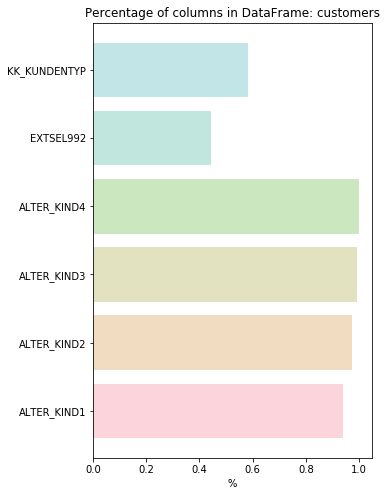

In [13]:
display_null_columns(customers,'customers',list_customers_columns_nulls,0.30)

### - Dropping columns

#List of columns with missing values greater than % are:


''''
ALTER_KIND1 - No information

ALTER_KIND2 - No information

ALTER_KIND3 - No information

ALTER_KIND4 - No information



KK_KUNDENTYP - consumption movement in the last 12 months
'''

In [14]:
customers.drop(list_customers_columns_nulls, axis=1,inplace=True)


### a.2) General AZDIAS DataFrame: Demographics data for the general population of Germany

In [15]:
### a)- Customers DataFrame:

In [16]:
azdias.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [17]:

azdias.describe()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


### - Analizing missing data in AZDIAS dataframe

In [18]:
# Number of no missing columns
n_no_missing_columns = len(azdias.columns[azdias.isnull().mean()==0])
print(n_no_missing_columns)

93


In [19]:
###DROPING COLUMNS

In [20]:
# Sum nulls values in each row
sum(azdias.isnull().sum(axis=1))


33492923

In [21]:
# List of columns with a more than  % nulla
list_azdias_columns_nulls = find_columns_nulls(azdias,0.30)


print(list_azdias_columns_nulls)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


#List of columns with missing values greater than 50% are:

'''

ALTER_KIND1 - No information

ALTER_KIND2 - No information

ALTER_KIND3 - No information

ALTER_KIND4 - No information


KK_KUNDENTYP - consumption movement in the last 12 months
'''

0.9090483729624863
0.9669004657655059
0.9930769135826019
0.9986479223447383
0.7339963937115486
0.6559674873011295


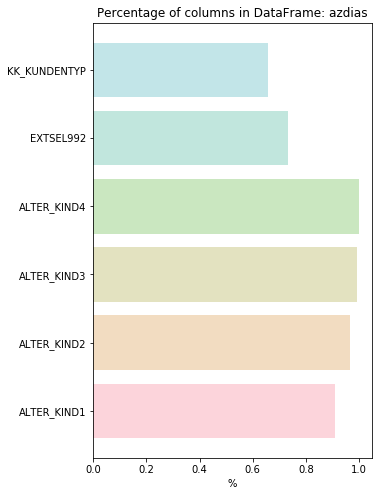

In [22]:
# showing the number of columns with % nulls
display_null_columns(azdias,'azdias',list_azdias_columns_nulls,0.30)


### - Dropping columns

In [23]:
azdias.drop(list_azdias_columns_nulls,axis=1,inplace=True)

In [24]:
# Find the percentage of missing values NaN in each column of AZDIAS, rounded to 2 decimal places
#missing_perct_column = azdias.isnull().mean(axis=0)

In [25]:
#columns_to_drop = missing_perct_column[missing_perct_column > 0.2].index

#columns_to_drop

In [26]:
#azdias.drop(labels=columns_to_drop, axis=1, inplace=True)

In [27]:
# checking AZDIAS dataset shape
#azdias.shape

In [28]:
#azdias = azdias[missing_perct_row < 0.2]

In [29]:
#azdias.shape

### b.1) Loading Attributes files

In [30]:
dias_attributes_val = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header=1)
dias_attributes_levels = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header=1)


In [31]:
#dias_attributes_val

In [32]:
#dias_attributes_levels

### b.2) Discard columns with nulls in atributes file 


In [33]:
dias_attributes_val_new = dias_attributes_val[dias_attributes_val.index.isin(list_azdias_columns_nulls)==False]
dias_attributes_val_new.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


In [34]:
dias_attributes_levels_new = dias_attributes_levels[dias_attributes_levels.index.isin(list_azdias_columns_nulls)==False]
dias_attributes_levels_new.head()

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


### b.3a) Refill the "Information level" column with ffil in attibutes info file

In [35]:
dias_attributes_levels_new.reset_index(drop=True, inplace=True)
dias_attributes_levels_new['Information level'].ffill(inplace=True)
dias_attributes_levels_new

dias_attributes_levels_new['Information level'].isnull().sum()

1

In [36]:
#we have still one null in Information level, we are going to apply bfill

In [37]:
dias_attributes_levels_new['Information level'].bfill(inplace=True)
dias_attributes_levels_new.head(25)

,Information level,Attribute,Description,Additional notes
0,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,Person,FINANZ_SPARER,financial typology: money saver,NaN
6,Person,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,Person,FINANZ_ANLEGER,financial typology: investor,NaN
8,Person,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,Person,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


### b.4) Refill the "Information level" column with ffil in attributes info file

In [38]:
# now all the column Information level is complete
#dias_attributes_levels_new['Information level'].isnull().sum()

In [39]:
### b.5) Filling the blanks 
#dias_attributes_levels_new.ffill(inplace=True)

In [40]:
#dias_attributes_levels_new.head(25)
#removing Additional notes
dias_attributes_levels_new.drop('Additional notes',axis=1,inplace=True)

In [41]:
### b.3a) Refill the  column with ffil in attibutes  values

In [42]:
dias_attributes_val_new.reset_index(drop=True, inplace=True)
dias_attributes_val_new.ffill(inplace=True)
dias_attributes_val_new

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [43]:
### b.4) to list all the unknows values

In [44]:
dias_attributes_val_unknowns = dias_attributes_val_new.loc[dias_attributes_val_new.Meaning=='unknown', :][['Attribute', 'Value']]
dias_attributes_val_unknowns.head(20)


#dias_attributes_val_unknowns= pd.Series(dias_attributes_val_new.Meaning=='unknown',dias_attributes_val_new['Value'].values, index=dias_attributes_val_new['Attribute'])


,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1
51,CAMEO_DEUG_2015,-1
105,CAMEO_DEUINTL_2015,-1
131,CJT_GESAMTTYP,0
391,D19_KK_KUNDENTYP,-1
647,EWDICHTE,-1


In [45]:
dias_attributes_val_unknowns.reset_index(drop=True, inplace=True)
#dias_attributes_unknowns.ffill(inplace=True)
dias_attributes_val_unknowns.head(20)


,Attribute,Value
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ANREDE_KZ,"-1, 0"
3,BALLRAUM,-1
4,BIP_FLAG,-1
5,CAMEO_DEUG_2015,-1
6,CAMEO_DEUINTL_2015,-1
7,CJT_GESAMTTYP,0
8,D19_KK_KUNDENTYP,-1
9,EWDICHTE,-1


In [46]:
### b.5) unknows. We can see there are differents kinds of unknows, for example -1,0 and both

In [47]:

def replace_unknowns(df, attributes_unknowns):
    '''
      Replace unkowns values for nan from dataframe df 
      
      :df -> Dataframe to change the value of attributes with unknows values
      :attributes_unknowns -> list of attributes whose are unknow 
      
      return
      
    '''
    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
        if column not in set(attributes_unknowns['Attribute']):
            continue
        
        unknown_value = attributes_unknowns.loc[attributes_unknowns['Attribute'] == column].Value.item()
        unknown_value = set(float(x) for x in unknown_value.split(', ')) if type(unknown_value) is str else set([float(unknown_value)])
        df[column] = df[column].mask(df[column].isin(unknown_value), other=np.nan)
    

    
    return df

In [48]:
#levels in attributes
#print(list(dias_attributes_val_unknowns['Information level'].unique()))

In [49]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,0.0,3.0,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [50]:

customer = replace_unknowns(customers, dias_attributes_val_unknowns)
customer.head(25)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626.0,2.0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,1.0,4.0
1,9628.0,NaN,9.0,11.0,NaN,NaN,NaN,0.0,3.0,NaN,...,3.0,NaN,9.0,NaN,3.0,FOOD,SINGLE_BUYER,0.0,1.0,4.0
2,143872.0,NaN,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,2.0,4.0
3,143873.0,1.0,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,...,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0.0,1.0,4.0
4,143874.0,NaN,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0.0,1.0,3.0
5,143888.0,1.0,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,...,1.0,6.0,9.0,1.0,2.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,1.0,3.0
6,143904.0,2.0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,...,2.0,6.0,9.0,7.0,1.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,1.0,4.0
7,143910.0,1.0,1.0,10.0,9.0,1.0,0.0,0.0,2.0,1.0,...,1.0,6.0,9.0,3.0,3.0,FOOD,SINGLE_BUYER,0.0,1.0,4.0
8,102160.0,2.0,3.0,5.0,4.0,74.0,2.0,0.0,1.0,82.0,...,9.0,6.0,3.0,4.0,3.0,COSMETIC,MULTI_BUYER,0.0,2.0,4.0
9,102173.0,1.0,1.0,20.0,13.0,1.0,0.0,0.0,3.0,1.0,...,4.0,2.0,9.0,5.0,1.0,COSMETIC,MULTI_BUYER,0.0,1.0,3.0


In [51]:
# AAAAAdroping columns that have more than 20% of missing values
#column_nans = azdias.isnull().mean()
#drop_cols = azdias.columns[column_nans > 0.20]
#print('columns to drop: ', drop_cols)

In [52]:
azdias = azdias.iloc[:100000]

azdias = replace_unknowns(azdias, dias_attributes_val_unknowns)
azdias.head(25)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220.0,NaN,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,NaN,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,NaN,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,910244.0,3.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0
6,910248.0,NaN,9.0,0.0,NaN,4.0,0.0,0.0,1.0,3.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4.0,2.0,2.0
7,910261.0,NaN,1.0,14.0,14.0,6.0,0.0,0.0,1.0,5.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1.0,1.0,1.0
8,645145.0,NaN,9.0,16.0,16.0,2.0,1.0,0.0,1.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6.0,1.0,3.0
9,645153.0,NaN,5.0,17.0,17.0,9.0,0.0,0.0,1.0,7.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4.0,2.0,3.0


In [53]:

def encode_col_PRAEGENDE(val):
    
    '''
    Re-encoding for the column -PRAEGENDE_JUGENDJAHRE-
    
    :val-> it´s the value to encode
    
    :return -> 0: Mainstream, 1: Avangarde
    '''
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    
    if val in mainstream: 
        return 0
    elif val in avantgarde: 
        return 1
    else:
        return val

In [54]:
azdias = azdias[azdias.isna().sum(axis=1)<=180]
customers = customers[customers.isna().sum(axis=1)<=183]

In [55]:


def encode_cols_LP(df):
    
    '''
    Re-encoding for  all the columns -LP_*-
    replacing zero with NaN values, dropping duplicate columns
    
    
    :df-> dataframe to treat LP_* columns
    
    :return df with encoding columns
    
    '''
    # droping complex and/or duplicate columns
    df.drop(['LP_FAMILIE_FEIN','LP_STATUS_FEIN','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
  
    # replacing 0s with NaN values
    cols = ["LP_LEBENSPHASE_FEIN","LP_LEBENSPHASE_GROB", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB"]
    df[cols] = df[cols].replace({0: np.nan})
    
    
    # re-encode LP_STATUS_GROB and LP_FAMILIE_GROB
    status = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3,  7: 3, 8: 4, 9: 4, 10: 5}
    familie = {1: 1, 2: 2, 3: 3, 4: 3, 5: 3, 6: 4, 7: 4, 8: 4, 9: 5, 10: 5, 11: 5}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(status)                                              
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(familie)    
    
    return df

In [56]:
def clean_data(df, attributes_values, nan_threshold):
     
    '''
    Cleaning data, an preprocessing in dataframe df
    
    :df-> DataFrame to treat data to clean up
    :attributes_values-> DataFrame attributes to located unknows values
    :nan_threshold-> limit for dropping rows with more than % NaN values
        
        
    :return df_cl-> df cleaned and preprocessed
    '''
    print("1")
    #replacing values X, XX with NaN values 
    #df.replace('X',np.nan,inplace=True)
    #df.replace('XX',np.nan,inplace=True)
    print("2")
    
    # dropping rows with %missing values highter than nan_threshold
    percent_missing_row = df.isnull().mean(axis=1) * 100
    df = df[percent_missing_row <= nan_threshold]

    # Reencoding CATEGORICAL & MIXED FEATURES. Processing datetime
    #df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    # df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    print("3")
    # treat 'X' and 'XX' as nan values
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    
    print("4")
    # Encoding binaries values
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # dropping categorical variables
    df.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis=1, inplace=True)
    
    print("5")
    # re encoding CAMEO_INTL_2015
    df['CAMEO_INTL_2015_WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['CAMEO_INTL_2015_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Re encoding columns LP*
    #df = encode_cols_LP(df)
    print('6')
    # re-encode PRAEGENDE_JUGENDJAHRE
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_col_PRAEGENDE(x))
    
    print('7')
    # impute missing values
    #imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer = Imputer(missing_values=np.nan, strategy='mean', axis=0)
    df_clean = pd.DataFrame(imputer.fit_transform(df))
    
    return df_clean

In [57]:
#customers = customers.iloc[:10000]
#azdias = azdias.iloc[:10000]

In [ ]:
customers_cleaned = clean_data(customers,dias_attributes_val_new, 30)

1
2
3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

4


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


5


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
customers.shape()

In [ ]:


#azdias_cleaned = clean_data(azdias,dias_attributes_val_new, 30)

In [ ]:
### b.7)  Data scaled


In [ ]:
## Using Data scaling  we can is a pre-processed step. This estimator scales and translates each feature individually so that it falls in the given range in the training set, for example, between zero and one.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
azdias_scaled = scaler.fit(azdias_cleaned)
customers_scaled = scaler.fit(customers_cleanead)

In [ ]:
customers_scaled = pd.read_pickle('customers_scaled.pkl')
customers_scaled.head()

In [ ]:
azdias_scaled = pd.read_pickle('azdias_scaled.pkl')
azdias_scaled.head()

In [ ]:
print('Covariance matrix: \n%s' %np.cov(azdias_scaled.T))

In [ ]:
### b.5) exclusive columns in customer and azdias 

In [ ]:
def get_exclusive_cols(df):
    attributes_without_info = []
    for col in df.columns:
        if col not in attributes_values.Attribute.values:
            attributes_without_info.append(col)
    return attributes_without_info


In [ ]:


dias_attributes_levels_new

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
### c) Appling sklearn PCA class

In [ ]:
# using PCA (Principal Component Analysis PCA) analysis we can reduce of dimensionality of our data without loss information.
# we can reduce complexity 

In [ ]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()


In [ ]:
pca_azdias = pca.fit(azdias_scaled)

In [ ]:
def show_plot(pca): 
    '''
    Creates a plot associated with the principal components 
    
    : pca -> the result of instantian of PCA in scikit learn
            
    Return ->graphic
    
    '''
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('Graphic:  Principal Components -  AZDIAS')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance')

plt.show()

In [ ]:
show_plot(pca_azdias)

In [ ]:
#customers pca

In [ ]:

print('NumPy covariance matrix: \n%s' %np.cov(customers_scaled.T))

In [ ]:
pca_customers = pca.fit_transform(customers_scaled)

In [ ]:
show_plot(pca_customers)

#---------sklearn's PCA class will be used to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, at least half the number of features will be set (so there's enough features to see the general trend in variability).
The ratio of variance explained by each principal component as well as the cumulative variance explained will be checked by plotting the cumulative or sequential values using matplotlib's plot() function. Based on the findings, a value for the number of transformed features will be retained for the clustering part of the project.
Once a choice for the number of components to keep has been made, the PCA instance will be re-fit to perform the decided-on transformation.


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train.shape

In [ ]:
sns.countplot('RESPONSE', data=mailout_train)